### Recurrent Neural Network (LSTM) Based Strategy Implementation
Implement RNN based strategy and optimize it on all symbols in the avarage ETFs amd Stocks set

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import pickle
import itertools
from backtesting import Backtest
from backtesting import Strategy

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kraken/Desktop/work/UoL/uol_final_tmp/venv/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

2023-09-24 08:53:26.109783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 08:53:26.130037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 08:53:26.130442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 08:53:26.598046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# change into Dataset't directory
os.chdir("../dataset")

In [3]:
with open("3_1_avg_stocks.pckl", "rb") as f:
    %time avg_Stocks = pickle.load(f)

CPU times: user 276 µs, sys: 219 µs, total: 495 µs
Wall time: 438 µs


In [4]:
with open("3_1_avg_etfs.pckl", "rb") as f:
    %time avg_ETFs = pickle.load(f)

CPU times: user 200 µs, sys: 159 µs, total: 359 µs
Wall time: 307 µs


In [5]:
with open("3_1_stock.pckl", "rb") as f:
    %time Stocks = pickle.load(f)

CPU times: user 734 ms, sys: 355 ms, total: 1.09 s
Wall time: 1.09 s


In [6]:
with open("3_1_etfs.pckl", "rb") as f:
    %time ETFs = pickle.load(f)

CPU times: user 16.1 ms, sys: 49 µs, total: 16.1 ms
Wall time: 16 ms


In [7]:
# Get symbol real names
ndt_reference = pd.read_csv("ndt_reference.csv")

In [8]:
avg_ETFs = pd.merge(avg_ETFs, ndt_reference[["Symbol", "Security Name"]], on="Symbol")
avg_Stocks = pd.merge(avg_Stocks, ndt_reference[["Symbol", "Security Name"]], on="Symbol")

### Preprocessing SPY's data

In [9]:
# Prepare first work on SPY
SPY = ETFs["SPY"].copy()
SPY = SPY[["Adj Close"]]
SPY["ret_pct"] = SPY["Adj Close"].pct_change()
# to introduce log normality.
SPY["log_ret_pct"] = np.log(1 + SPY["ret_pct"])
SPY.dropna(inplace=True)

In [10]:
SPY

,Adj Close,ret_pct,log_ret_pct
Date,,,
2000-01-04,93.693573,-0.039106,-0.039891
2000-01-05,93.861176,0.001789,0.001787
2000-01-06,92.352676,-0.016072,-0.016202
2000-01-07,97.716209,0.058077,0.056453
2000-01-10,98.051422,0.003430,0.003425
...,...,...,...
2023-08-28,442.760010,0.006341,0.006321
2023-08-29,449.160004,0.014455,0.014351
2023-08-30,451.010010,0.004119,0.004110


In [11]:
SPY.describe()

,Adj Close,ret_pct,log_ret_pct
count,5954.000000,5954.000000,5954.000000
mean,171.338935,0.000334,0.000257
std,112.609567,0.012417,0.012426
min,53.155308,-0.109424,-0.115887
25%,88.294670,-0.004804,-0.004815
50%,112.451721,0.000651,0.000650
75%,233.685982,0.006019,0.006001
max,477.709991,0.145198,0.135577


<Figure size 4000x1000 with 0 Axes>

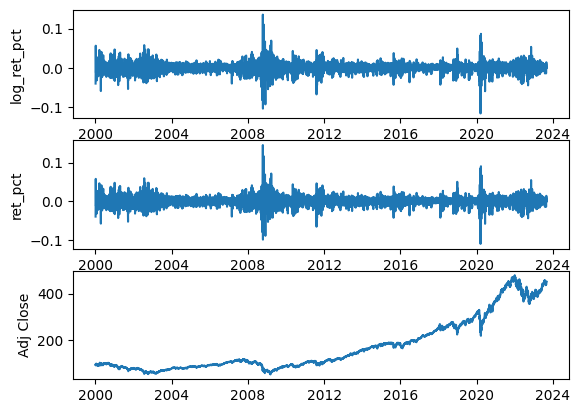

In [12]:
# Plot the column to show log normality and why the training will happen on log_ret_pct
# Ajd Close is very chaotic with big changes it would be hard for a model to understand even with scalingon its own.
#
# Both ret_pct and log_ret_pct mean is around zero
# log_ret_pct tracks better the smaller changes due to assumed log normality
# more info about that could be read here: https://quantivity.wordpress.com/2011/02/21/why-log-returns/
plt.figure(figsize=(40, 10))
fig, axis = plt.subplots(3, 1)

axis[2].plot(SPY.index, SPY["Adj Close"], label="Adj Close")
axis[2].set_ylabel("Adj Close")

axis[1].plot(SPY.index, SPY["ret_pct"], label="ret_pct")
axis[1].set_ylabel("ret_pct")

axis[0].plot(SPY.index, SPY["log_ret_pct"], label="log_ret_pct")
axis[0].set_ylabel("log_ret_pct")
plt.show()

In [13]:
# Scale SPY values
SPY_ = SPY[["Adj Close", "log_ret_pct"]].values
scaler = MinMaxScaler(feature_range=(0, 1)).fit(SPY_)
SPY_scaled = scaler.transform(SPY_)

In [14]:
SPY_scaled[0]

array([0.0954842 , 0.30221228])

In [15]:
# Set the number of observation that will be used to traing the LSTM
# use 63 based on 3 months or avaraged working day
time_step = 63

In [16]:
y = SPY_scaled[time_step: ,0]

In [17]:
X = []
for i in range(time_step, len(SPY_scaled)):
    X.append(SPY_scaled[i - time_step: i])

X = np.array(X)

In [18]:
X.shape

(5891, 63, 2)

In [19]:
# make sure that X and y len is matching
assert len(X) == len(y)

In [20]:
# split data into train, val and test sets

p_85 = int(len(X) * 0.85)
p_90 = int(len(X) * 0.90)

X_train, y_train = X[:p_90], y[:p_90]
X_val, y_val = X[p_85:p_90], y[p_85:p_90]
X_test, y_test = X[p_90:], y[p_90:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(5301, 63, 2) (5301,)
(294, 63, 2) (294,)
(590, 63, 2) (590,)


### Build RNN

In [21]:
observation, step, features = X.shape

In [22]:
rnn = Sequential([
    LSTM(units=32,
         input_shape=(step, features),
         name="LSTM_1",
         dropout=0.2,
         recurrent_dropout=0.2,
         return_sequences=True),
    LSTM(units=16,
         name="LSTM_2",
         dropout=0.2,
         recurrent_dropout=0.2),
    Dense(10, name="DENSE_1"),
    Dense(10, name="DENSE_2"),
    Dense(1, name="Output")
])

2023-09-24 08:53:28.594720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 08:53:28.596442: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 63, 32)            4480      
                                                                 
 LSTM_2 (LSTM)               (None, 16)                3136      
                                                                 
 DENSE_1 (Dense)             (None, 10)                170       
                                                                 
 DENSE_2 (Dense)             (None, 10)                110       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 7907 (30.89 KB)
Trainable params: 7907 (30.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
rnn_1 = keras.models.clone_model(rnn)
rnn_2 = keras.models.clone_model(rnn)

rnn_1.compile(loss='mean_squared_error', optimizer="adam")
rnn_2.compile(loss='mae', optimizer="RMSProp")

### Train RNN 1

In [25]:
metric = 'val_loss'
rnn_path = "../models/rnn_1_spy_2.weights.best"
tb_path = "../tensorboard/rnn_1_spy"

In [26]:
tensorboard = TensorBoard(log_dir=tb_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [27]:
early_stopping = EarlyStopping(monitor=metric, 
                              patience=5,
                              restore_best_weights=True)

In [28]:
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor=metric,
                              save_best_only=True,
                              save_weights_only=True,
                              save_freq="epoch")

In [29]:
result_1 = rnn_1.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_val, y_val),
                 callbacks=[checkpointer, early_stopping, tensorboard],
                 verbose=1)

Epoch 1/100
166/166 [==============================] - 6s 26ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 2/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 3/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/100
166/166 [==============================] - 4s 24ms/step - loss: 9.3095e-04 - val_loss: 0.0020
Epoch 5/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
166/166 [==============================] - 4s 24ms/step - loss: 8.0455e-04 - val_loss: 0.0021


### Train RNN 2

In [30]:
metric = 'val_loss'
rnn_path = "../models/rnn_2_spy_2.weights.best"
tb_path = "../tensorboard/rnn_2_spy"

In [31]:
tensorboard = TensorBoard(log_dir=tb_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [32]:
early_stopping = EarlyStopping(monitor=metric, 
                              patience=5,
                              restore_best_weights=True)

In [33]:
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor=metric,
                              save_best_only=True,
                              save_weights_only=True,
                              save_freq="epoch")

In [34]:
result_2 = rnn_2.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_val, y_val),
                 callbacks=[checkpointer, early_stopping, tensorboard],
                 verbose=1)

Epoch 1/100
166/166 [==============================] - 6s 26ms/step - loss: 0.0379 - val_loss: 0.0304
Epoch 2/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0282 - val_loss: 0.0783
Epoch 3/100
166/166 [==============================] - 4s 25ms/step - loss: 0.0262 - val_loss: 0.0458
Epoch 4/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0257 - val_loss: 0.0824
Epoch 5/100
166/166 [==============================] - 4s 25ms/step - loss: 0.0249 - val_loss: 0.0609
Epoch 6/100
166/166 [==============================] - 4s 24ms/step - loss: 0.0244 - val_loss: 0.0369


### Compare train results

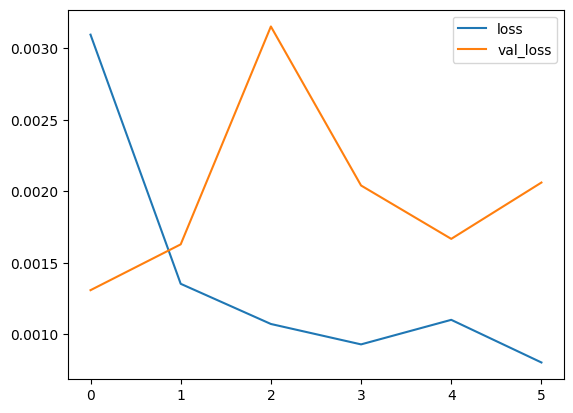

In [35]:
pd.DataFrame(result_1.history).plot();

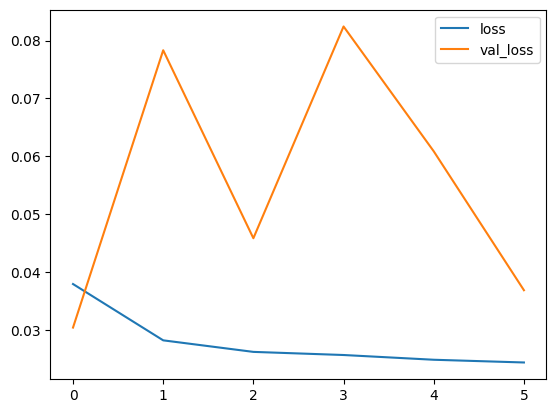

In [36]:
pd.DataFrame(result_2.history).plot();

In [37]:
# Create predictions
y_pred_1 = rnn_1.predict(X_test)
y_pred_2 = rnn_2.predict(X_test)
y_pred_full_1 = rnn_1.predict(X)
y_pred_full_2 = rnn_2.predict(X)

185/185 [==============================] - 1s 6ms/step


In [38]:
# Scale back predictions with scaler object
y_pred_1 = np.c_[y_pred_1, np.zeros(y_pred_1.shape)]
y_pred_1 = scaler.inverse_transform(y_pred_1)
y_pred_1 = [x[0] for x in y_pred_1]

y_pred_2 = np.c_[y_pred_2, np.zeros(y_pred_2.shape)]
y_pred_2 = scaler.inverse_transform(y_pred_2)
y_pred_2 = [x[0] for x in y_pred_2]

y_pred_full_1 = np.c_[y_pred_full_1, np.zeros(y_pred_full_1.shape)]
y_pred_full_1 = scaler.inverse_transform(y_pred_full_1)
y_pred_full_1 = [x[0] for x in y_pred_full_1]

y_pred_full_2 = np.c_[y_pred_full_2, np.zeros(y_pred_full_2.shape)]
y_pred_full_2 = scaler.inverse_transform(y_pred_full_2)
y_pred_full_2 = [x[0] for x in y_pred_full_2]


In [39]:
# check only the data rows that have predictions
SPY = SPY.iloc[time_step:].copy()

In [40]:
SPY["RNN 1 Full"] = y_pred_full_1
SPY["RNN 2 Full"] = y_pred_full_2
SPY.loc[SPY.index[len(SPY) - len(y_pred_1):], "RNN 1 Test"] = y_pred_1
SPY.loc[SPY.index[len(SPY) - len(y_pred_2):], "RNN 2 Test"] = y_pred_2


In [41]:
SPY

,Adj Close,ret_pct,log_ret_pct,RNN 1 Full,RNN 2 Full,RNN 1 Test,RNN 2 Test
Date,,,,,,,
2000-04-04,100.905151,-0.007438,-0.007466,101.927509,100.424515,NaN,NaN
2000-04-05,100.275024,-0.006245,-0.006264,102.201598,100.714983,NaN,NaN
2000-04-06,101.146713,0.008693,0.008655,102.434921,100.929226,NaN,NaN
2000-04-07,101.787308,0.006333,0.006313,102.676366,101.237629,NaN,NaN
2000-04-10,101.388298,-0.003920,-0.003928,102.926235,101.575558,NaN,NaN
...,...,...,...,...,...,...,...
2023-08-28,442.760010,0.006341,0.006321,418.419265,418.663640,418.419215,418.663614
2023-08-29,449.160004,0.014455,0.014351,418.254881,418.577652,418.254881,418.577702
2023-08-30,451.010010,0.004119,0.004110,418.381029,418.772984,418.381003,418.772984


In [42]:
training_error_1 = np.sqrt(rnn_1.evaluate(X_train, y_train, verbose=0))
testing_error_1 = np.sqrt(rnn_1.evaluate(X_test, y_test, verbose=0))
print('Training Error 1: {:.4f} | Test Error 1: {:.4f}'.format(training_error_1, testing_error_1))

Training Error 1: 0.0170 | Test Error 1: 0.0536


In [43]:
training_error_2 = np.sqrt(rnn_2.evaluate(X_train, y_train, verbose=0))
testing_error_2 = np.sqrt(rnn_2.evaluate(X_test, y_test, verbose=0))
print('Training Error 2: {:.4f} | Test Error 2: {:.4f}'.format(training_error_2, testing_error_2))

Training Error 2: 0.1275 | Test Error 2: 0.2090


# Plot the two RNNs predictions

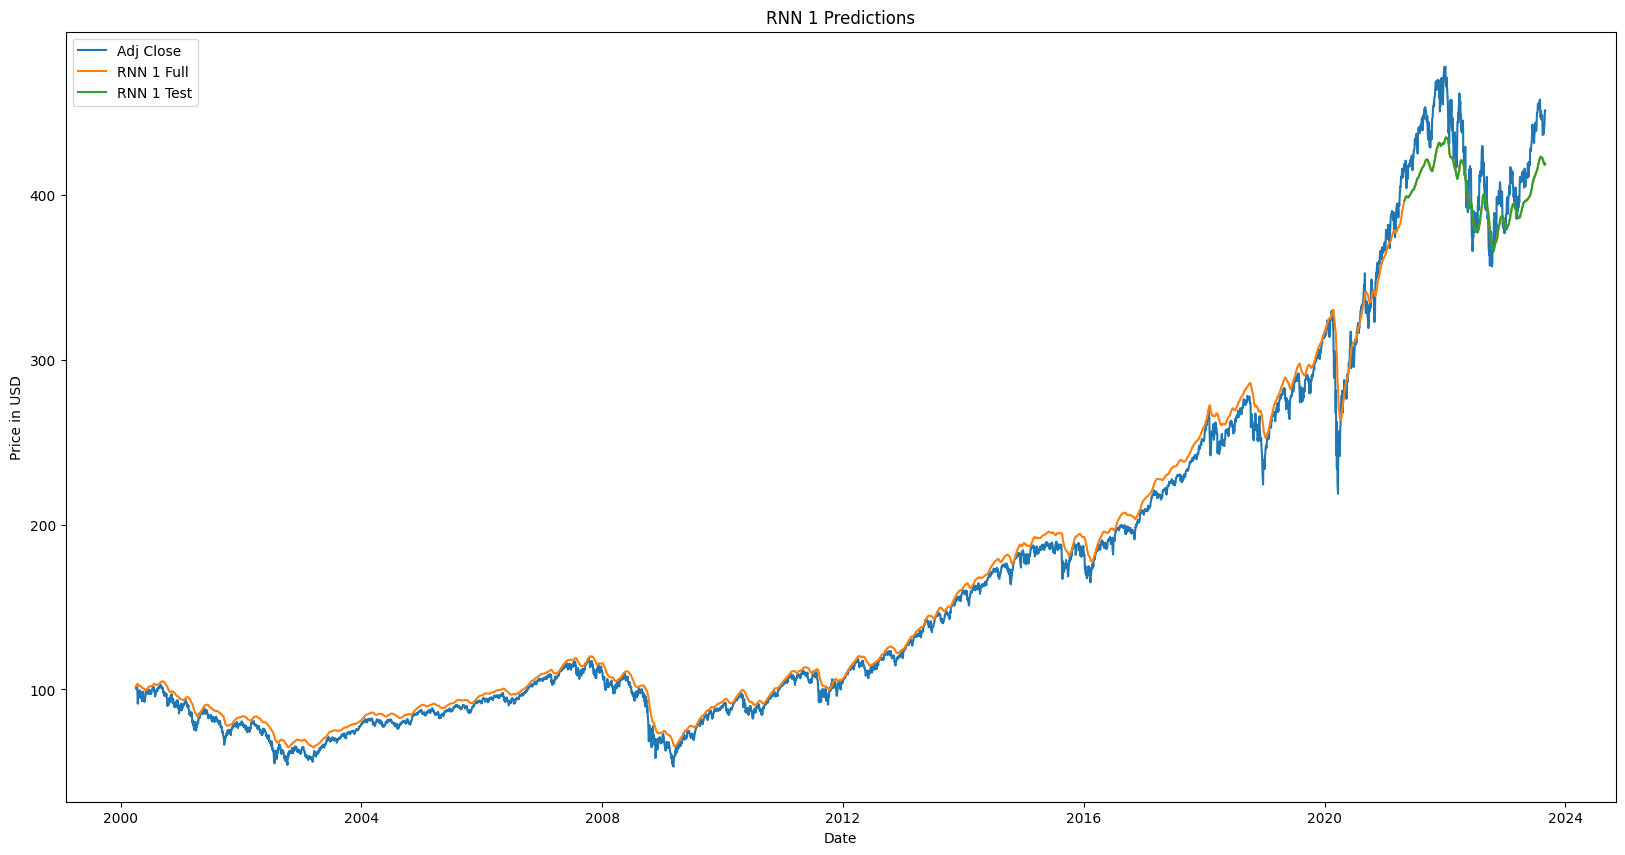

In [44]:
# Plot RNN 1 reslts
plt.figure(figsize=(20,10))

plt.plot(SPY.index, SPY["Adj Close"], label="Adj Close")
plt.plot(SPY.index, SPY["RNN 1 Full"], label="RNN 1 Full")
plt.plot(SPY.index, SPY["RNN 1 Test"], label="RNN 1 Test")

plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.title("RNN 1 Predictions")
plt.show()

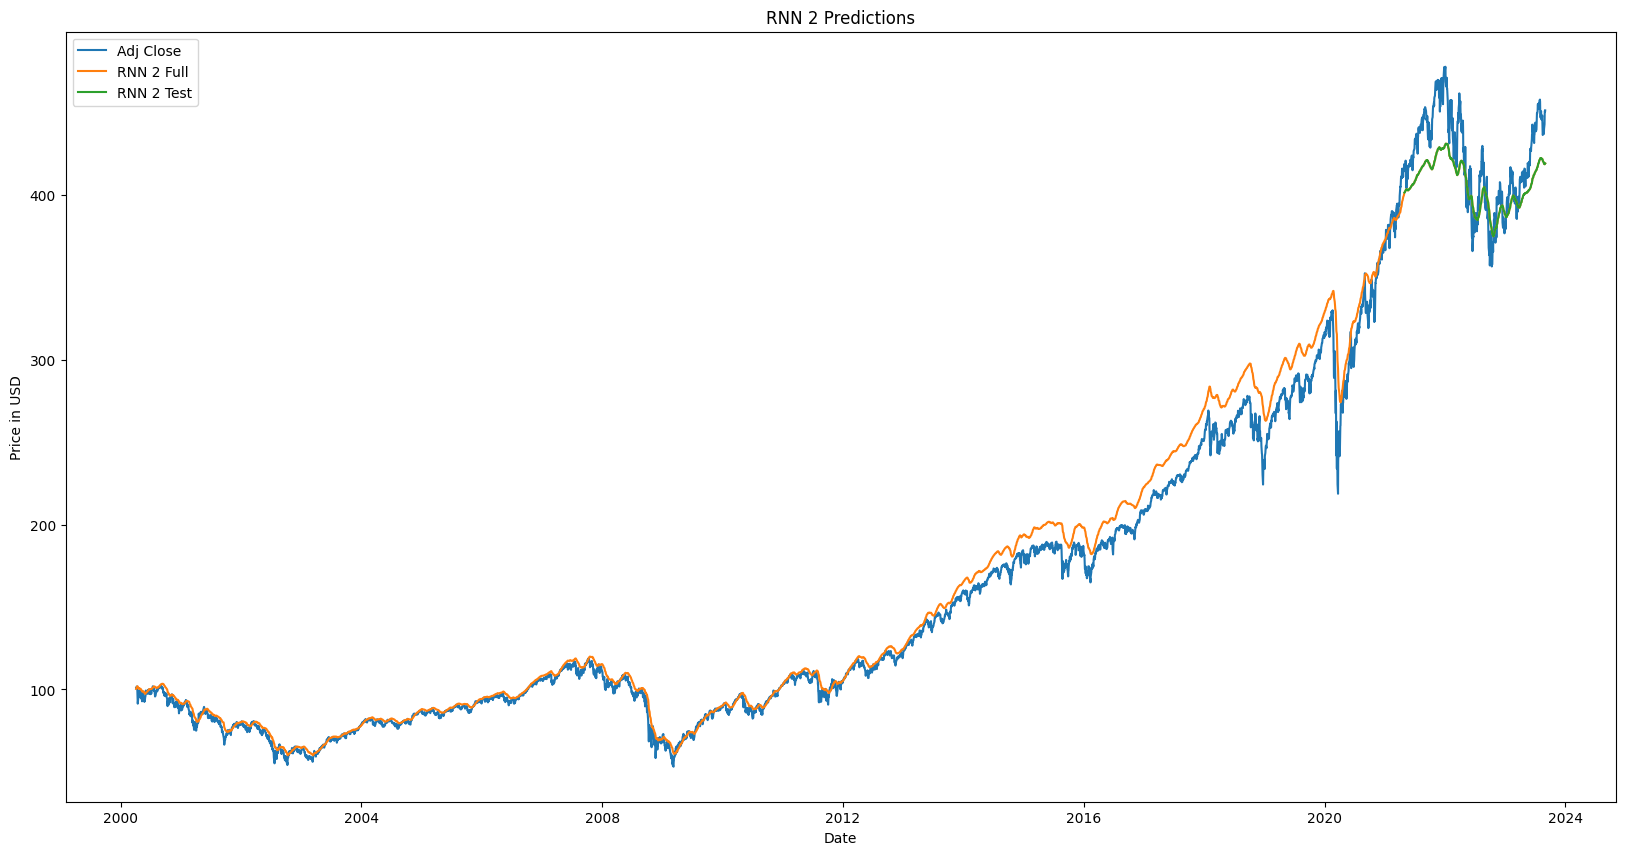

In [45]:
# Plot RNN 2 reslts
plt.figure(figsize=(20,10))

plt.plot(SPY.index, SPY["Adj Close"], label="Adj Close")
plt.plot(SPY.index, SPY["RNN 2 Full"], label="RNN 2 Full")
plt.plot(SPY.index, SPY["RNN 2 Test"], label="RNN 2 Test")

plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.title("RNN 2 Predictions")
plt.show()

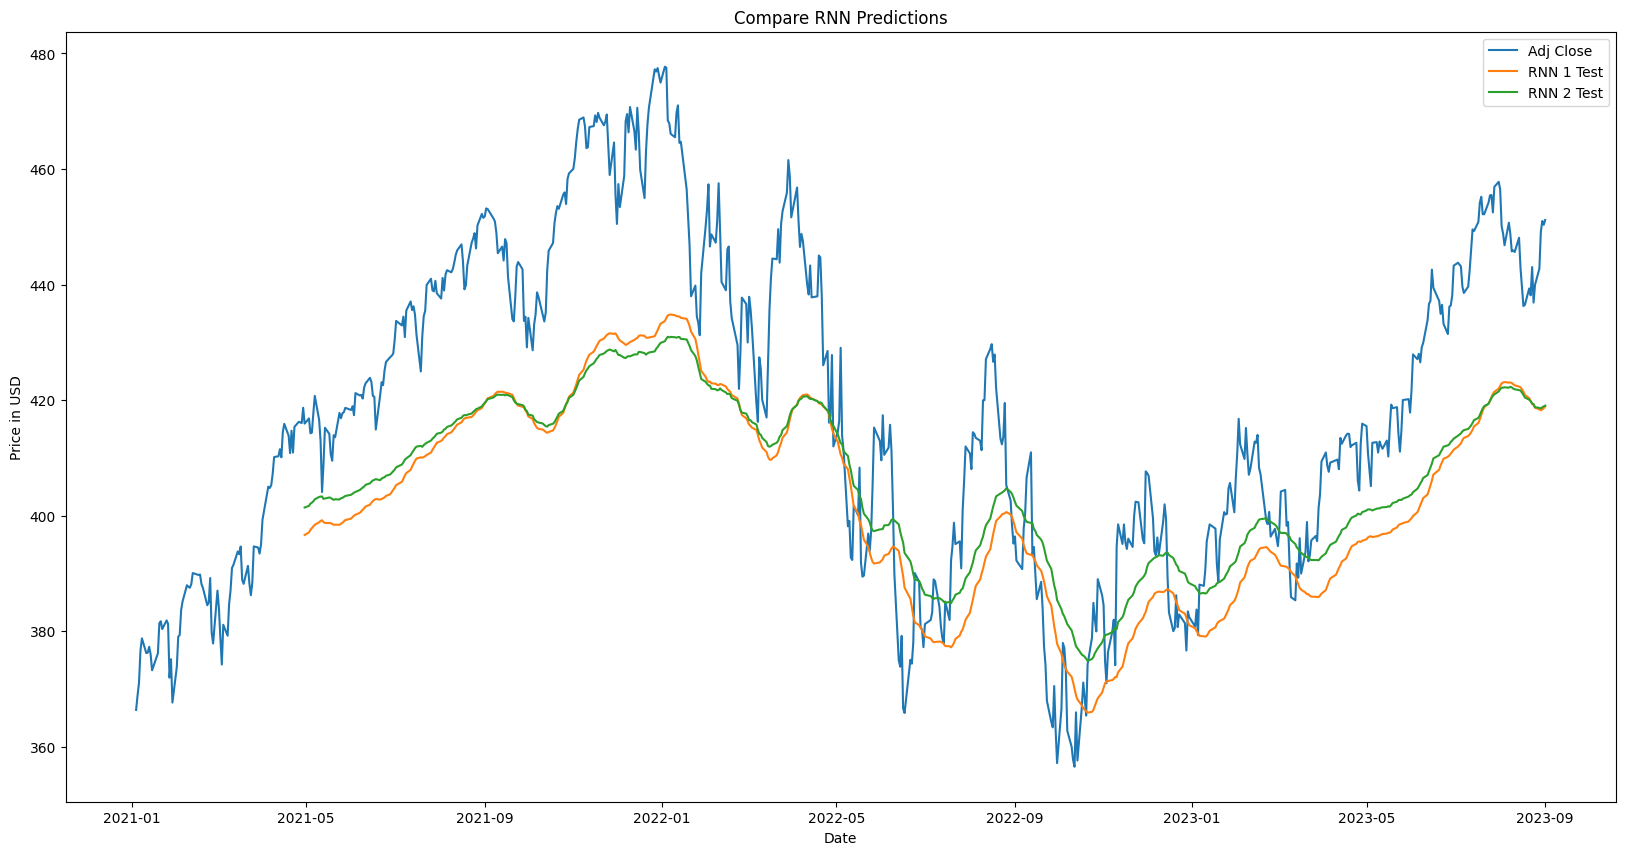

In [46]:
# Compare only the test predictions

SPY_ = SPY.loc["2021-01-03":]

# Plot RNN 2 reslts
plt.figure(figsize=(20,10))

plt.plot(SPY_.index, SPY_["Adj Close"], label="Adj Close")
plt.plot(SPY_.index, SPY_["RNN 1 Test"], label="RNN 1 Test")
plt.plot(SPY_.index, SPY_["RNN 2 Test"], label="RNN 2 Test")

plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.title("Compare RNN Predictions")
plt.show()